In [55]:
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

In [56]:
from utilities.utilities import *
from utilities.diffGrad import *
from models.FCN import *
from models.FourierFCN import FourierFCN2D

In [223]:
w, l, T = 1.0, 1.0, 1.0
size = 10
dim = 2

In [224]:
E = 1
nu= 0.25

lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu  = E / (2 + 2 * nu)

In [225]:
equations = {
    'equation-1': {
        'points': get_points(fixed={}, size=size, dim=dim),
        'derivatives': [(0, ), (0, 0), (0, 0, 0), (0, 1, 1), (2, 0)],
        'phi': lambda u, u_x, u_xx, u_yy, p_x: -u * u_x + u_xx + u_yy - p_x,
        'psi': lambda x: torch.tensor([[0.0]]),
        'regularization': 1.0
    },
    'equation-2': {
        'points': get_points(fixed={}, size=size, dim=dim),
        'derivatives': [(1, ), (1, 1), (1, 0, 0), (1, 1, 1), (2, 1)],
        'phi': lambda v, v_y, v_xx, v_yy, p_y: -v * v_y + v_xx + v_yy - p_y,
        'psi': lambda x: torch.tensor([[0.0]]),
        'regularization': 1.0
    },
    'equation-3': {
        'points': get_points(fixed={}, size=size, dim=dim),
        'derivatives': [(0, 0), (1, 1)],
        'phi': lambda u_x, v_y: u_x + v_y,
        'psi': lambda x: torch.tensor([[0.0]]),
        'regularization': 1.0
    }
}

In [226]:
MSE = lambda x: torch.mean(torch.abs(x) ** n)

In [227]:
points = true_solution[:, :2]
points = torch.tensor(points, dtype=torch.float).to(device)

function_values = true_solution[:, 2:]
function_values = np.sqrt(function_values[:, 0] ** 2 + function_values[:, 1] ** 2)[:, None]

In [228]:
layer_size = 16
epochs = 2500
n = 2.
restarts = 1

In [229]:
results = dict()
for (NET, name, activation) in [(FCNCustom, 'FCN [min(sin(x), x)]', lambda x: torch.min(torch.sin(x), x)), 
                                (FCNCustom, 'FCN [max(tanh(x), x)]', lambda x: torch.max(torch.tanh(x), x)),
                                (FCNCustom, 'FCN [sigmoid(x) * x]', lambda x: torch.sigmoid(x) * x), 
                                (FCNCustom, 'FCN [cos(x)]', lambda x: torch.cos(x)), 
                                (FCNCustom, 'FCN [tanh]', lambda x: torch.tanh(x))]:
    training_errors = []
    fem_test_errors = []
    for _ in range(restarts):

        net = NET(output_dim=3, layer_size=layer_size, activate=activation)
        errors, _ = training(net, equations, epochs=epochs, optimizer=optim.AdamW, loss=MSE)
        training_errors += [errors]

    net.name = 'Navier-Stokes [{}][1:{}]'.format(name, layer_size)
    net.save_model()

    results[name] = {
        'training_errors': training_errors,
        'best_model': net
    }

100%|██████████| 2501/2501 [00:23<00:00, 106.04it/s]


In [232]:
results_ = dict()

In [239]:
results.keys()

dict_keys(['FCN [min(sin(x), x)]', 'FCN [max(tanh(x), x)]', 'FCN [sigmoid(x) * x]', 'FCN [cos(x)]', 'FCN [tanh]'])

In [240]:
results_['FCN [cos] without orthogonality'] = results['FCN [cos(x)]']
results_['FCN [cos] with orthogonality'] = results['FCN [sigmoid(x) * x]']
results_['FCN [Chebyshev]'] = results['FCN [max(tanh(x), x)]']
results_['FCN [tanh]'] = results['FCN [min(sin(x), x)]']

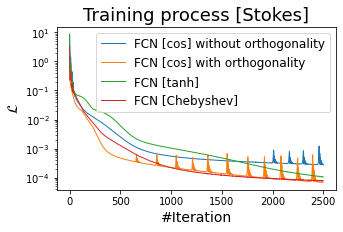

In [274]:
plt.figure(figsize=(5, 3))

plt.title('Training process [Stokes]', fontsize=18)
for i, (name, values) in enumerate(results_.items()):
    
    errors = np.array(values['training_errors'])
    mean = np.mean(errors, axis=0)
    std = np.std(errors, axis=0)
    plt.semilogy(mean, label='{}'.format(name), linewidth=1)
#     plt.semilogy(mean + std)
#     plt.semi

plt.xlabel('#Iteration', fontsize=14)
plt.ylabel(r'$\mathcal{L}$', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [221]:
def plot_solutions(function_values, points, figsize=(8, 5), mesh=None):
    plt.figure(figsize=figsize)
    plt.title('NN (x)')
    plt.scatter(points[:, 0], points[:, 1], c=function_values)
    plt.colorbar()
    plt.show()

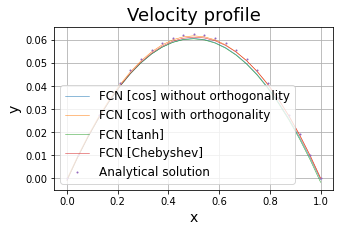

In [268]:
plt.figure(figsize=(5, 3))
plt.title('Velocity profile', fontsize=18)
for name, values in results_.items():
    if name == 'ChebNET':
        continue
    points = get_points(fixed={0: 1.0}, size=25)
    net = values['best_model']
    function_values_net = net(points)
    function_values_net = function_values_net.cpu().detach().numpy()
    points = points.cpu().detach().numpy()
    plt.plot(points[:, 1], function_values_net[:, 0], label=name, linewidth=0.5)
    
p1 = 0.5
p2 = 0.0

v = (p1 - p2) / (2) * (0.5 ** 2 - (points[:, 1] - 0.5) ** 2)

plt.plot(points[:, 1], v, 'o', markersize=1, label='Analytical solution')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

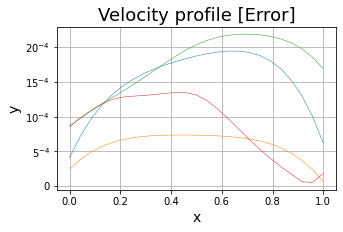

In [269]:
plt.figure(figsize=(5, 3))
plt.title('Velocity profile [Error]', fontsize=18)
v = (p1 - p2) / (2) * (0.5 ** 2 - (points[:, 1] - 0.5) ** 2)
for name, values in results_.items():
    if name == 'ChebNET':
        continue
    points = get_points(fixed={0: 1.0}, size=25)
    net = values['best_model']
    function_values_net = net(points)
    function_values_net = function_values_net.cpu().detach().numpy()
    points = points.cpu().detach().numpy()
    plt.plot(points[:, 1], np.abs(v - function_values_net[:, 0]), label=name, linewidth=0.5)
    
p1 = 0.5
p2 = 0.0

# plt.plot(points[:, 1], v, 'o', markersize=8, label='Analytical solution')
plt.yticks(ticks=[0.0, 5 * 10 ** (-4), 10 * 10 ** (-4), 15 * 10 ** (-4), 20 * 10 ** (-4)], labels=['0', r'$5^{-4}$', r'$10^{-4}$', r'$15^{-4}$', r'$20^{-4}$'])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
# plt.legend(fontsize=12)
plt.grid()
plt.show()

In [162]:
class ChebFCN2D(nn.Module):
    def __init__(self, layer_size = 8, output_dim=3, save_folder='trained_models', **kwargs):
        super().__init__()
        
        self.layer_size = layer_size
        self.path = save_folder
        self.output_dim = output_dim
        self.linear = nn.Linear((layer_size - 1) * (layer_size - 1) + 1, self.output_dim)
        
        
    def prepaire(self, x):
        x_pp = torch.ones_like(x)
        x_p  = torch.ones_like(x) * x
        X = torch.cat((x_pp, x_p), 1)
        for l in range(2, layer_size):
            xc = 2 * x * x_p - x_pp
            X = torch.cat((X, xc), 1)
            x_pp = x_p
            x_p  = xc
        return X
    
    def product(self, X, Y):
        
        R = torch.ones_like(X[:, 0][:, None])
        for i in range(1, self.layer_size):
            for j in range(1, self.layer_size):
                R = torch.cat((R, self._product(X[:, i], Y[:, j])), 1)
        return R
    
    def _product(self, x, y):
        return (x * y)[:, None]
        
    def forward(self, x):
        
        X = self.prepaire(x[:, 0][:, None])
        Y = self.prepaire(x[:, 1][:, None])
        
        R = self.product(X, Y)
        output = self.linear(R)
        
        return output
    
    def save_model(self):
        torch.save(self.state_dict(), '{}/{}.pt'.format(self.path, self.name))